<a href="https://colab.research.google.com/github/hicksjr2/ISA444-Final-Project/blob/main/ISA444_timecopilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TimeCopilot

### Import libraries

In [ ]:
!pip install TimeCopilot
import pandas as pd

from timecopilot import TimeCopilotForecaster
from timecopilot.models.foundation.chronos import Chronos
from timecopilot.models.foundation.moirai import Moirai
from timecopilot.models.foundation.timesfm import TimesFM
from timecopilot.models.stats import AutoARIMA, SeasonalNaive

from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mase, scaled_crps

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


In [28]:
# Load your Nixtla/TimeCopilot-format panel
df = pd.read_csv("downsampled_df.csv", parse_dates=["ds"])

print(df.head())
print("Number of series:", df["unique_id"].nunique())

  unique_id         ds          y
0      10_2 2010-02-05  123952.48
1      10_2 2010-02-12  119209.48
2      10_2 2010-02-19  121430.80
3      10_2 2010-02-26  120292.15
4      10_2 2010-03-05  113163.91
Number of series: 40


### Plot the Data

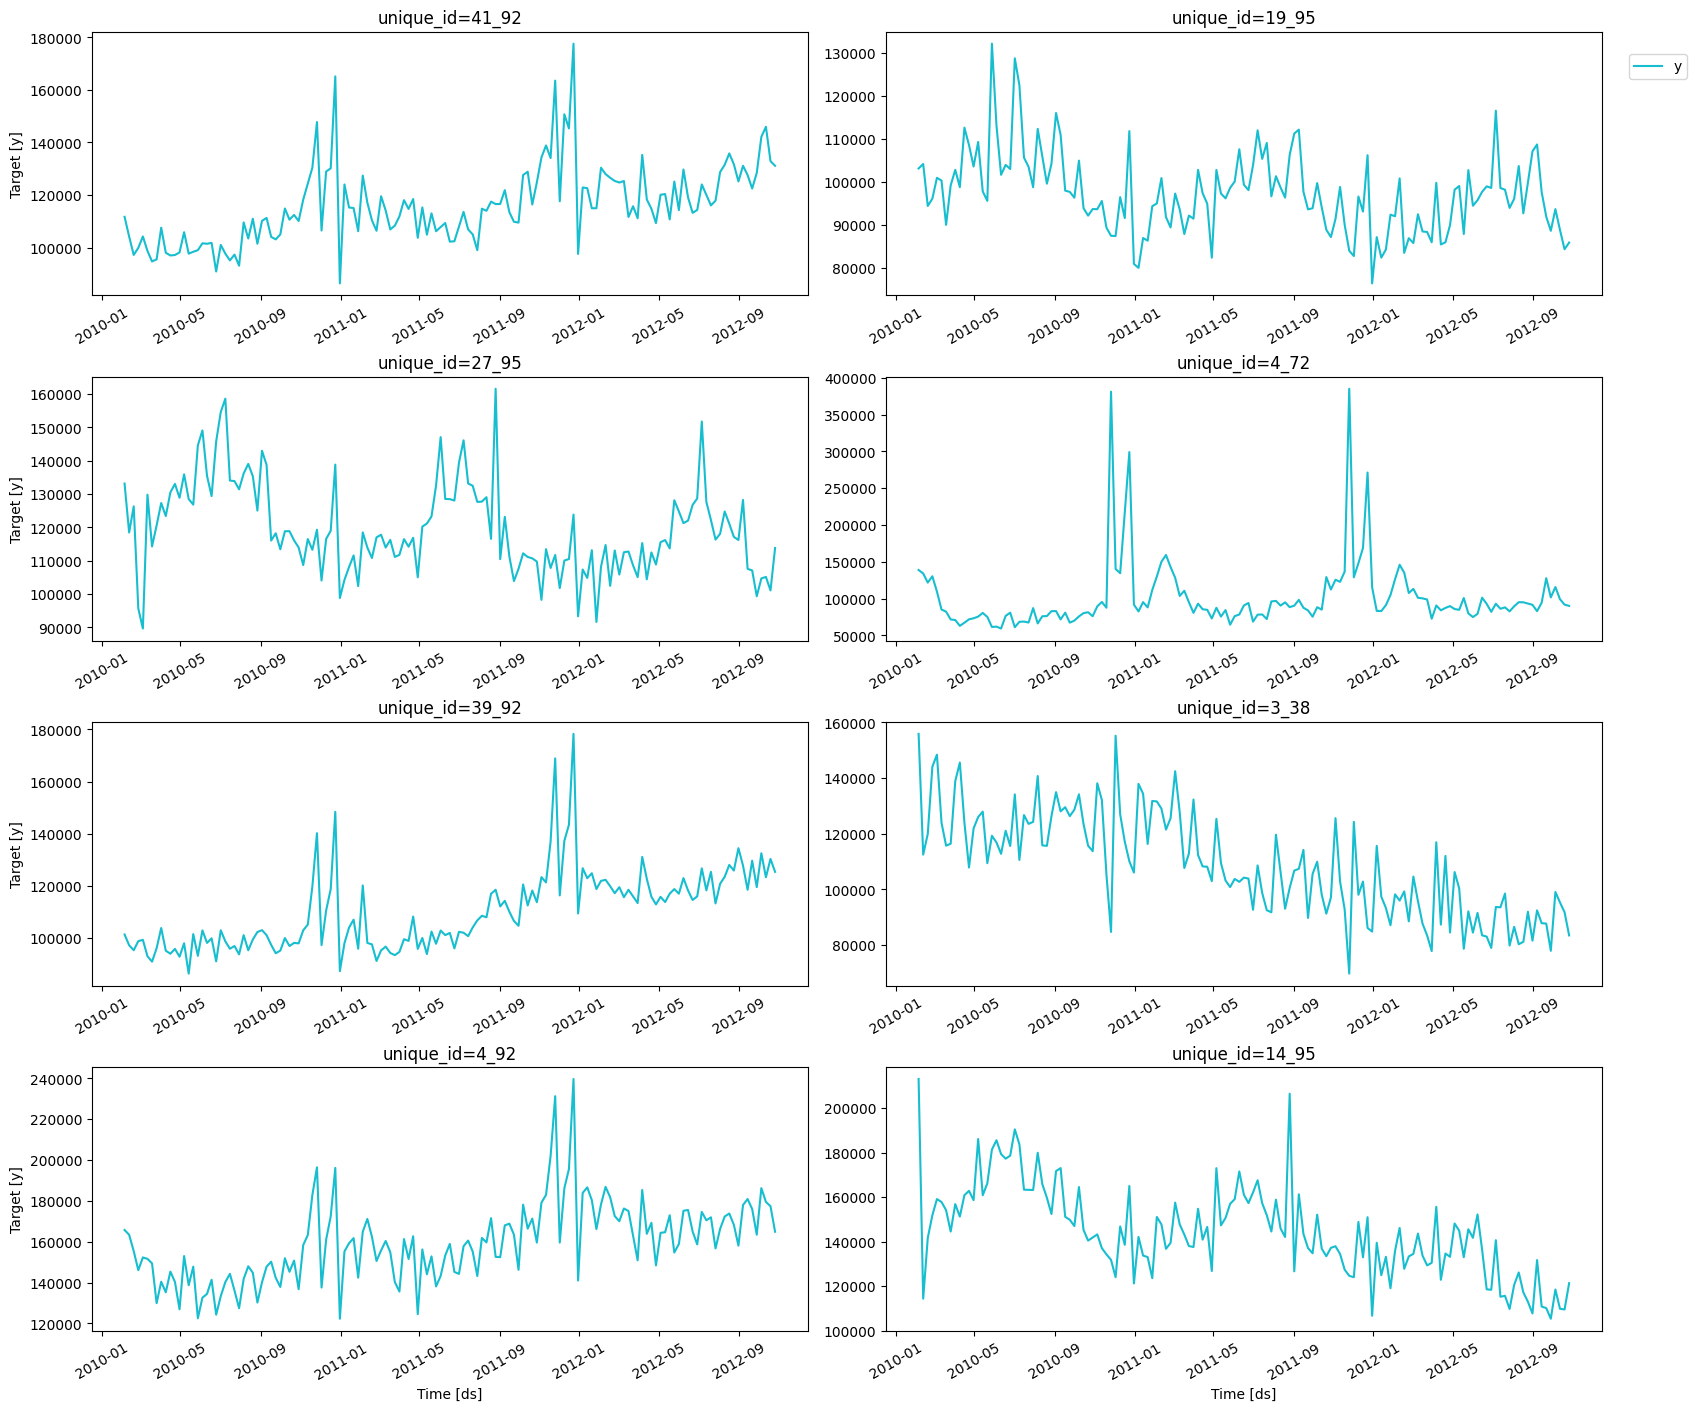

In [29]:
TimeCopilotForecaster.plot(df)

### Create a TimeCoPilotForecaster

In [ ]:
tcf = TimeCopilotForecaster(
    models=[
        AutoARIMA(),
        Chronos(repo_id="amazon/chronos-bolt-small"),
        Moirai(),
        TimesFM(repo_id="google/timesfm-2.5-200m-pytorch", alias="TimesFM-2.5"),
        TimesFM(repo_id="google/timesfm-2.0-500m-pytorch", alias="TimesFM-2.0"),
        SeasonalNaive(season_length=52),  # weekly data ≈ yearly seasonality
    ]
)

In [ ]:
# !pip install statsforecast mlforecast neuralforecast utilsforecast xgboost lightgbm
import pandas as pd
# !pip install torch

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, AutoETS, AutoARIMA

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from xgboost import XGBRegressor

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae as mae_metric

# ============================================================
# 0) LOAD DOWNSIZED DATA
# ============================================================

# Make sure this file is in the same folder as your .py script
CSV_PATH = "downsampled_df.csv"   # change name here if needed

df = pd.read_csv(CSV_PATH)

# Ensure columns exist
expected_cols = {"unique_id", "ds", "y"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing columns: {missing}. Expected: {expected_cols}")

# Parse dates and sort
df["ds"] = pd.to_datetime(df["ds"])
df = df.sort_values(["unique_id", "ds"]).reset_index(drop=True)

# If you want to limit number of series to speed things up, uncomment:
# uids = df["unique_id"].unique()[:10]
# df = df[df["unique_id"].isin(uids)].reset_index(drop=True)

Y_df = df[["unique_id", "ds", "y"]]

# ============================================================
# GLOBAL CV CONFIG
# ============================================================

freq = "W"          # weekly data
h = 13              # forecast horizon (weeks)
n_windows = 5       # 5-fold
step_size = h       # non-overlapping

# 1) STATSFORECAST: Naive, Seasonal Naive, AutoETS, AutoARIMA
# ============================================================

print("\n================ STATSFORECAST MODELS ================")

sf = StatsForecast(
    models=[
        Naive(),
        SeasonalNaive(season_length=52),
        AutoETS(season_length=52),
        AutoARIMA(season_length=52),
    ],
    freq=freq,
    n_jobs=1,   # keep 1 to avoid multiprocessing issues
)

cv_sf = sf.cross_validation(
    df=Y_df,
    h=h,
    n_windows=n_windows,
    step_size=step_size,   # non-overlapping windows
)

sf_metrics = evaluate(
    cv_sf.drop(columns="cutoff"),
    metrics=[rmse, mae_metric],
)

print("StatsForecast metrics (Naive, SNaive, AutoETS, AutoARIMA):")
print(sf_metrics)

import pandas as pd

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae as mae_metric

# ============================================================
# 1) LOAD DATA
# ============================================================

train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

train["Date"] = pd.to_datetime(train["Date"])
features["Date"] = pd.to_datetime(features["Date"])

# Merge Walmart data
full = (
    train
    .merge(features, on=["Store", "Date", "IsHoliday"], how="left")
    .merge(stores, on="Store", how="left")
)

# Build unique_id and Nixtla format
full["unique_id"] = full["Store"].astype(str) + "_" + full["Dept"].astype(str)
full = full.rename(columns={"Date": "ds", "Weekly_Sales": "y"})

panel = full[["unique_id", "ds", "y"]].copy()
panel = panel.sort_values(["unique_id", "ds"]).reset_index(drop=True)

# ============================================================
# 2) MAKE REGULAR WEEKLY PANEL
# ============================================================

def make_regular_weekly_panel(df_panel, freq="W-FRI"):
    out = []
    for uid, g in df_panel.groupby("unique_id"):
        g = g.sort_values("ds").set_index("ds")
        full_idx = pd.date_range(g.index.min(), g.index.max(), freq=freq)
        g = g.reindex(full_idx)
        g["unique_id"] = uid
        g["y"] = g["y"].fillna(0)
        g = g.reset_index().rename(columns={"index": "ds"})
        out.append(g)
    return pd.concat(out, ignore_index=True)

freq = "W-FRI"
Y_reg = make_regular_weekly_panel(panel, freq=freq)

# Filter short series
h = 13
n_windows = 5
max_lag = 52
min_len = n_windows*h + max_lag

lengths = Y_reg.groupby("unique_id")["ds"].size()
good_ids = lengths[lengths >= min_len].index
Y_ml = Y_reg[Y_reg["unique_id"].isin(good_ids)].reset_index(drop=True)

# ============================================================
# 3) VALID CUSTOM DATE FEATURES FOR MLF (Pandas 2.x safe)
# ============================================================

date_features = {
    "week": lambda x: x.dt.isocalendar().week.astype(int),
    "month": lambda x: x.dt.month.astype(int),
}

# ============================================================
# 4) SET UP LIGHTGBM + MLFORECAST
# ============================================================

mlf = MLForecast(
    models=[
        LGBMRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=-1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="regression",
            n_jobs=-1,
        )
    ],
    freq=freq,
    lags=[1, 2, 3, 4, 7, 13, 26, 52],
    target_transforms=[],
    date_features=date_features,   # <-- NEW fixed date features
)

# Fit LightGBM
mlf.fit(
    df=Y_ml,
    id_col="unique_id",
    time_col="ds",
    target_col="y",
)

# 5-fold CV
cv_ml = mlf.cross_validation(
    df=Y_ml,
    n_windows=n_windows,
    h=h,
    id_col="unique_id",
    time_col="ds",
    target_col="y",
    step_size=h,
)

ml_metrics = evaluate(
    cv_ml.drop(columns="cutoff"),
    metrics=[rmse, mae_metric],
)

print("LightGBM 5-fold CV metrics:")
print(ml_metrics)


# ============================================================
# PART 4 — NeuralForecast: AutoNBEATS & AutoNHITS
# ============================================================

# Use a single CV window for shorter series
n_windows_nf = 1          # <= key change
step_size_nf = h          # non-overlapping

print("\n================ NEURALFORECAST (AutoNBEATS & AutoNHITS) ================")

try:
    from neuralforecast import NeuralForecast
    from neuralforecast.auto import AutoNBEATS, AutoNHITS
    from neuralforecast.losses.pytorch import MAE as MAETrain
    import logging

    logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

    models_nf = [
        AutoNBEATS(
            h=h,
            loss=MAETrain(),
            num_samples=2,
            backend="optuna",
        ),
        AutoNHITS(
            h=h,
            loss=MAETrain(),
            num_samples=2,
            backend="optuna",
        ),
    ]

    nf = NeuralForecast(
        models=models_nf,
        freq=freq,
    )

    cv_nf = nf.cross_validation(
        Y_df,
        n_windows=n_windows_nf,   # 1 window
        step_size=step_size_nf,   # usually = h
        refit=1,
    )

    nf_metrics = evaluate(
        cv_nf.drop(columns="cutoff"),
        metrics=[rmse, mae_metric],
    )

    print("NeuralForecast (AutoNBEATS & AutoNHITS) metrics:")
    print(nf_metrics)

except Exception as e:
    print("NeuralForecast AutoNBEATS/AutoNHITS failed with error:")
    print(repr(e))



================ STATSFORECAST MODELS ================
StatsForecast metrics (Naive, SNaive, AutoETS, AutoARIMA):
   unique_id metric         Naive  SeasonalNaive       AutoETS     AutoARIMA
0       10_2   rmse  11439.611995    4942.558329   8059.653092   8481.825348
1      10_40   rmse   6034.598758    3646.311859   5865.557464   6328.346455
2      10_72   rmse  67852.753548   30267.056204  33208.505603  67802.056966
3      13_90   rmse  12199.775745   13064.951950  10078.438032   9445.983725
4      13_92   rmse  20638.236597   21444.050393  16508.169241  16959.092555
..       ...    ...           ...            ...           ...           ...
75     41_92    mae  13667.225846   10943.848923   9582.958128   9821.215354
76      4_72    mae  20239.428154   14752.358615  14616.735667  21551.371764
77      4_92    mae  19027.837846   17541.977231  12141.451817  11030.120396
78      4_95    mae   9789.131231   11808.939077   9870.530870   9685.632211
79      6_92    mae  10818.877692    7

[I 2025-12-04 20:30:58,604] A new study created in memory with name: no-name-f9b30b88-1634-4341-854f-8cf722bf85ef
INFO:lightning_fabric.utilities.seed:Seed set to 18


LightGBM 5-fold CV metrics:
     unique_id metric  LGBMRegressor
0         10_1   rmse   16678.713564
1        10_10   rmse    4414.369942
2        10_11   rmse    4745.140405
3        10_12   rmse     995.666406
4        10_13   rmse    3523.687663
...        ...    ...            ...
6105      9_91    mae     248.594405
6106      9_92    mae    3188.899413
6107      9_94    mae     490.424188
6108      9_95    mae    3676.864010
6109      9_96    mae     559.973867

[6110 rows x 3 columns]

================ NEURALFORECAST (AutoNBEATS & AutoNHITS) ================


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-12-04 20:32:41,953] Trial 0 finished with value: 232086.40625 and parameters: {'learning_rate': 0.0464556153981321, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256, 'windows_batch_size': 512, 'random_seed': 18, 'input_size': 52, 'step_size': 13}. Best is trial 0 with value: 232086.40625.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-12-04 20:33:24,763] Trial 1 finished with value: 9343.783203125 and parameters: {'learning_rate': 0.0294327881655972, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 256, 'windows_batch_size': 128, 'random_seed': 1, 'input_size': 39, 'step_size': 13}. Best is trial 1 with value: 9343.783203125.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-12-04 20:34:08,816] A new study created in memory with name: no-name-cadc8bd1-a915-4a18-9e21-2ef981009aed
INFO:lightning_fabric.utilities.seed:Seed set to 13


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-12-04 20:37:09,587] Trial 0 finished with value: 10571.62890625 and parameters: {'n_pool_kernel_size': [2, 2, 2], 'n_freq_downsample': [24, 12, 1], 'learning_rate': 0.00020629560922150249, 'scaler_type': 'robust', 'max_steps': 900.0, 'batch_size': 128, 'windows_batch_size': 512, 'random_seed': 13, 'input_size': 39, 'step_size': 13}. Best is trial 0 with value: 10571.62890625.
INFO:lightning_fabric.utilities.seed:Seed set to 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-12-04 20:38:34,790] Trial 1 finished with value: 10190.9677734375 and parameters: {'n_pool_kernel_size': [4, 4, 4], 'n_freq_downsample': [1, 1, 1], 'learning_rate': 0.0003269538931009171, 'scaler_type': 'standard', 'max_steps': 900.0, 'batch_size': 128, 'windows_batch_size': 128, 'random_seed': 20, 'input_size': 39, 'step_size': 13}. Best is trial 1 with value: 10190.9677734375.
INFO:lightning_fabric.utilities.seed:Seed set to 20


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

NeuralForecast (AutoNBEATS & AutoNHITS) metrics:
   unique_id metric    AutoNBEATS     AutoNHITS
0       10_2   rmse   6480.537998  13807.247860
1      10_40   rmse   7115.690520   3971.887411
2      10_72   rmse  73382.665306  25097.414169
3      13_90   rmse   9866.680827   7671.852071
4      13_92   rmse  12907.834145   9624.598148
..       ...    ...           ...           ...
75     41_92    mae  11447.233774   5613.259447
76      4_72    mae  45172.726130  12456.561298
77      4_92    mae  11677.633317   4093.042788
78      4_95    mae  11465.172115   6800.077644
79      6_92    mae  10948.670505  14652.245817

[80 rows x 4 columns]


### Generate forecast via cross-validation

In [ ]:
level = [0, 95]

cv_df = tcf.cross_validation(
    df=df,
    h=12,         # 12 weeks ahead
    freq="W-FRI"  # Friday weekly data
)


1it [00:32, 32.90s/it]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:03<00:00,  1.06s/it]
1it [00:09,  9.35s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [09:31, 571.86s/it]
40it [11:58, 17.95s/it]
1it [12:08, 728.57s/it]
0it [00:00, ?it/s]
100%|██████████| 1/1 [01:06<00:00, 66.42s/it]
1it [01:14, 74.06s/it]
0it [00:00, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing dataframe with single process.
Finished preprocessing dataframe.


1it [01:34, 94.51s/it]


Finished forecasting.


1it [00:00,  2.29it/s]


In [ ]:
cv_df

,unique_id,ds,cutoff,y,AutoARIMA,Chronos,Moirai,TimesFM-2.5,TimesFM-2.0,SeasonalNaive
0,10_2,2012-08-10,2012-08-03,112523.39,107241.199409,112640.0,107864.109375,117210.382812,115291.421875,116330.25
1,10_2,2012-08-17,2012-08-03,113259.20,105619.628480,112640.0,107861.335938,115277.359375,112589.914062,119858.79
2,10_2,2012-08-24,2012-08-03,106630.07,105177.011034,109568.0,109357.859375,108564.046875,108356.976562,106724.02
3,10_2,2012-08-31,2012-08-03,95671.50,105008.664594,107520.0,108983.031250,106479.296875,104786.546875,108981.34
4,10_2,2012-09-07,2012-08-03,106094.76,104904.124390,107008.0,108497.656250,105384.828125,103129.492188,106874.02
...,...,...,...,...,...,...,...,...,...,...
475,6_92,2012-09-28,2012-08-03,90778.91,101210.959601,95232.0,99591.281250,90351.671875,93952.843750,85760.01
476,6_92,2012-10-05,2012-08-03,105457.17,100325.208626,98304.0,96914.585938,95689.820312,98644.953125,100861.53
477,6_92,2012-10-12,2012-08-03,107386.22,100550.828052,101888.0,98662.609375,100570.203125,100924.960938,99228.65
478,6_92,2012-10-19,2012-08-03,100390.24,99943.435978,102912.0,98272.648438,99061.781250,99646.890625,91903.91


### Plot results

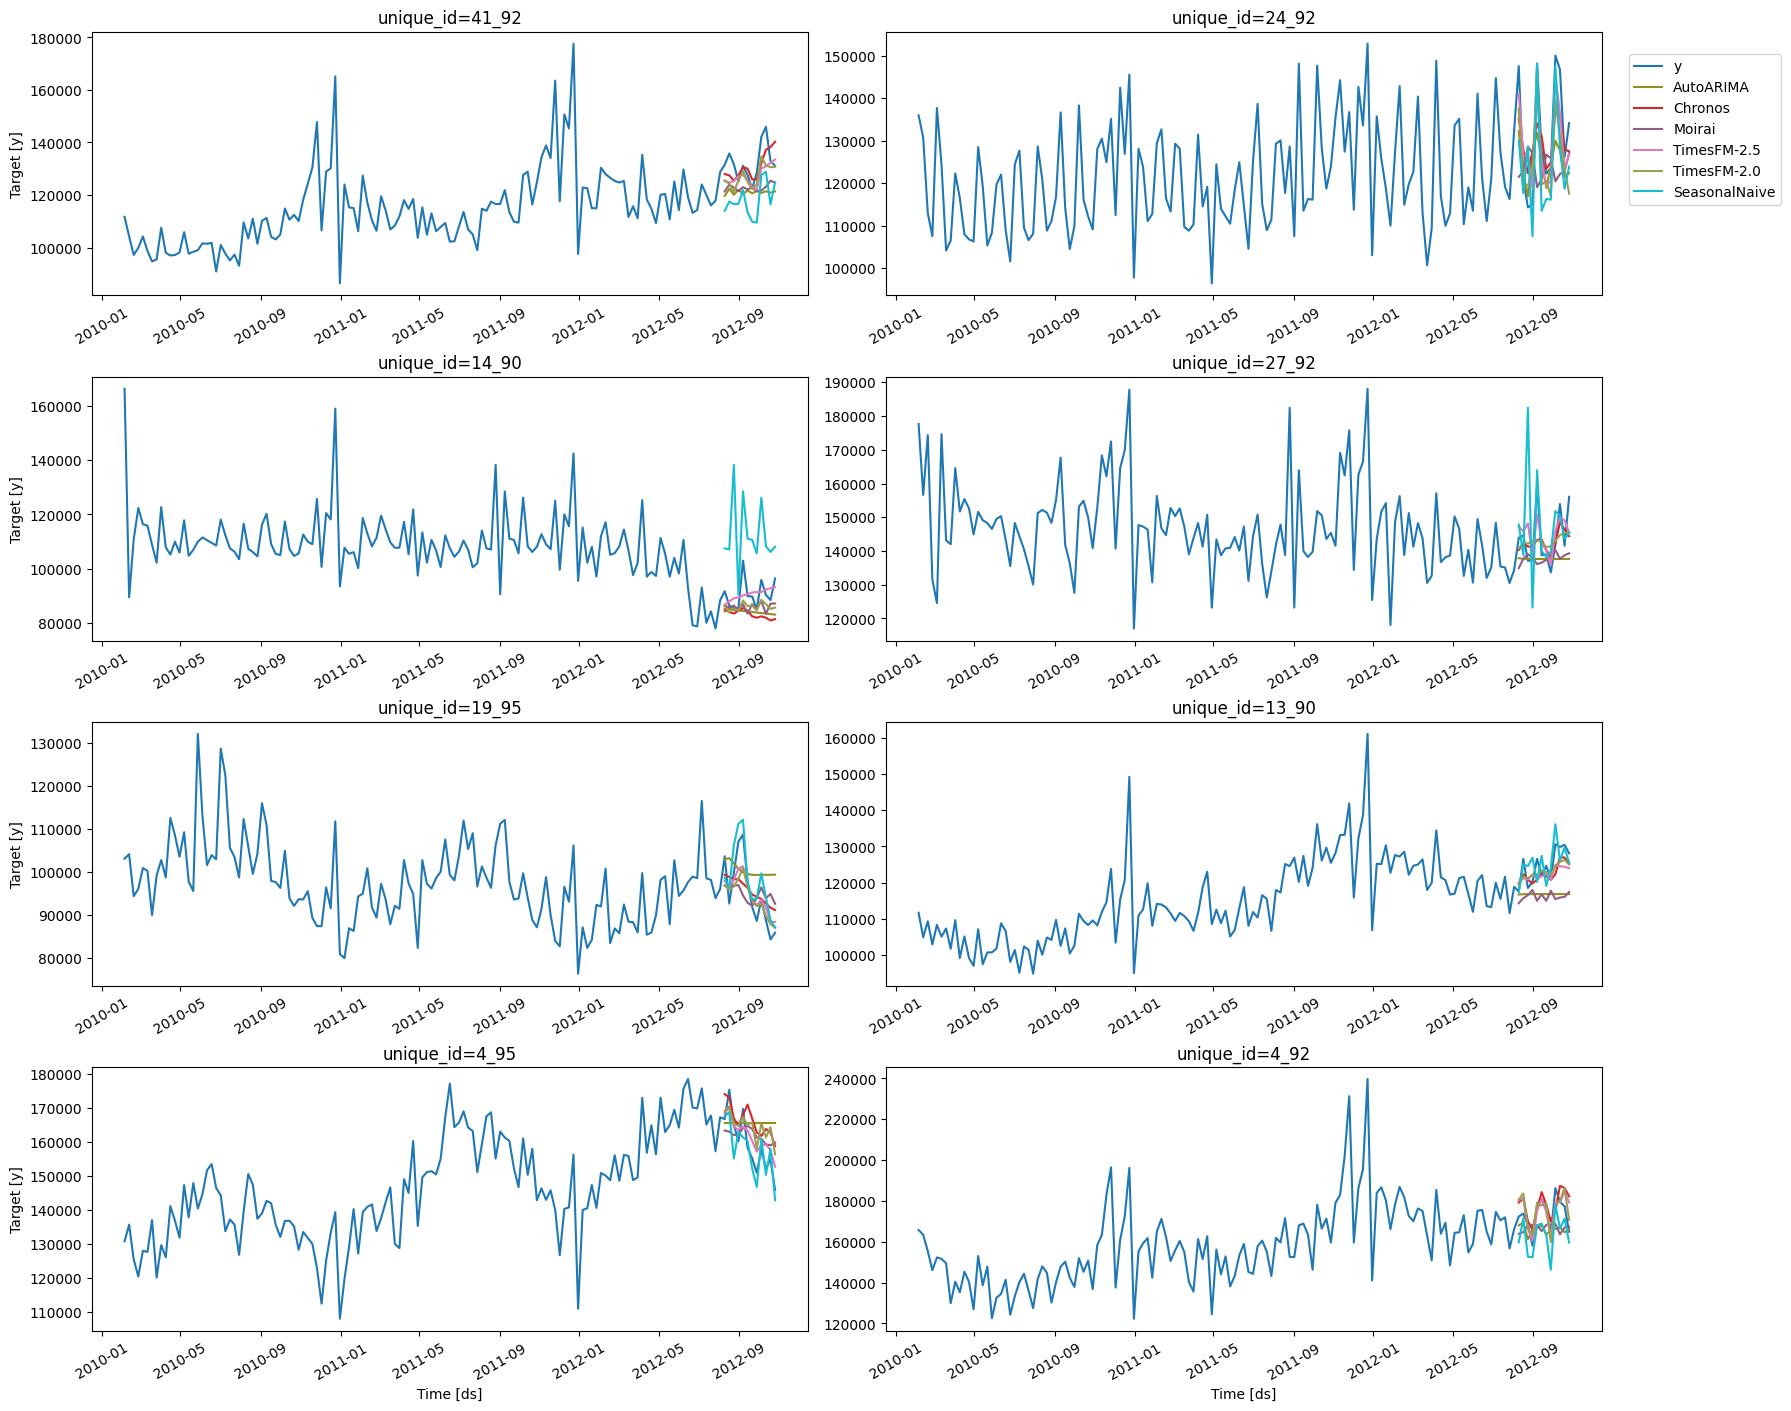

In [50]:
tcf.plot(
    df,
    cv_df.drop(columns=["cutoff", "y"])
)

### Evaluation

In [31]:
# Determine training period based on the first cutoff used in cross-validation
first_cutoff = cv_df["cutoff"].min()

train_df = df[df["ds"] <= first_cutoff]
print("Train period ends at:", first_cutoff)

Train period ends at: 2012-08-03 00:00:00


In [33]:
eval_df = evaluate(
    cv_df.drop(columns=["cutoff"]),
    train_df=df,
    metrics=[partial(mase, seasonality=52)], # weekly seasonality ≈ 52
)

summary = (
    eval_df.groupby("metric")
           .mean(numeric_only=True)
           .T
           .sort_values(by="mase") # Sort by MASE as scaled_crps is removed
           .round(3)
)

print(summary)

metric          mase
TimesFM-2.5    0.563
TimesFM-2.0    0.570
Chronos        0.654
AutoARIMA      0.847
Moirai         0.901
SeasonalNaive  0.984


In [35]:
# pip install statsforecast mlforecast neuralforecast timecopilot timegpt nixtla metricsforecast # uncomment and run if needed

import os
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

# statsforecast imports (for ETS / ARIMA / Naive)
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, AutoETS, AutoARIMA

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [36]:
# paths (change if needed)
DATA_DIR = "."   # where train.csv, features.csv, stores.csv live
Y_PATH = "downsampled_df.csv"
FEATURES_PATH = os.path.join(DATA_DIR, "features.csv")
STORES_PATH = os.path.join(DATA_DIR, "stores.csv")

# load
Y_df = pd.read_csv(Y_PATH, parse_dates=["ds"])
features = pd.read_csv(FEATURES_PATH, parse_dates=["Date"])
stores = pd.read_csv(STORES_PATH)

# Quick rename to be clear
features = features.rename(columns={"Date":"ds", "IsHoliday":"isHoliday"})
# features contains columns: ds, Store, Temperature, Fuel_Price, MarkDown1..5, CPI, Unemployment, isHoliday
# stores contains: Store, Type, Size

# Extract Store and Dept from unique_id (if needed)
Y_df[["Store","Dept"]] = Y_df["unique_id"].str.split("_", expand=True).astype(int)

# Merge features (left join by Store+ds)
X_df = pd.merge(Y_df[["unique_id","ds","Store"]].drop_duplicates(), features, how="left",
                left_on=["Store","ds"], right_on=["Store","ds"])

# Merge store-level static features
X_df = pd.merge(X_df, stores, how="left", left_on="Store", right_on="Store")

# Now drop Store column if you don't need it as exogenous
# Keep the exogenous features you'd like to use
exog_cols = ["Temperature","Fuel_Price","CPI","Unemployment","isHoliday","Type","Size"]
for c in exog_cols:
    if c not in X_df.columns:
        print("Warning: feature missing:", c)

X_df = X_df[["unique_id","ds"] + [c for c in exog_cols if c in X_df.columns]]

# Show sample
print("Y_df sample:")
print(Y_df.head())
print("\nX_df sample:")
print(X_df.head())


Y_df sample:
  unique_id         ds          y  Store  Dept
0      10_2 2010-02-05  123952.48     10     2
1      10_2 2010-02-12  119209.48     10     2
2      10_2 2010-02-19  121430.80     10     2
3      10_2 2010-02-26  120292.15     10     2
4      10_2 2010-03-05  113163.91     10     2

X_df sample:
  unique_id         ds  Temperature  Fuel_Price         CPI  Unemployment  \
0      10_2 2010-02-05        54.34       2.962  126.442065         9.765   
1      10_2 2010-02-12        49.96       2.828  126.496258         9.765   
2      10_2 2010-02-19        58.22       2.915  126.526286         9.765   
3      10_2 2010-02-26        52.77       2.825  126.552286         9.765   
4      10_2 2010-03-05        55.92       2.877  126.578286         9.765   

   isHoliday Type    Size  
0      False    B  126512  
1       True    B  126512  
2      False    B  126512  
3      False    B  126512  
4      False    B  126512  


In [49]:
# reindex each series to weekly Fridays
def reindex_series(df_y):
    out = []
    for uid, g in df_y.groupby("unique_id"):
        g = g.set_index("ds").sort_index()
        start = g.index.min()
        end = g.index.max()
        full_idx = pd.date_range(start=start, end=end, freq="W-FRI")
        g = g.reindex(full_idx)
        g.index.name = "ds"
        g["unique_id"] = uid
        # keep original y values and leave NaN where missing
        out.append(g.reset_index())
    return pd.concat(out, ignore_index=True)

Y_full = reindex_series(Y_df[["unique_id","ds","y"]])
print("After reindex, rows:", len(Y_full))
print(Y_full.groupby("unique_id")["y"].apply(lambda s: s.isna().sum()).head())

# Optionally impute NaNs -- choose a method
# For many forecasting pipelines, fill missing y with 0 or forward fill.
# We'll forward-fill then fill remaining NaNs with 0 (adjust if you prefer)
Y_full["y"] = Y_full.groupby("unique_id")["y"].transform(lambda s: s.ffill().bfill().fillna(0))

After reindex, rows: 5720
unique_id
10_2     0
10_40    0
10_72    0
13_90    0
13_92    0
Name: y, dtype: int64


In [38]:
h = 12
min_history = 5*h + 12  # rough heuristic
lens = Y_full.groupby("unique_id").size()
eligible = lens[lens >= min_history].index.tolist()

print("Total series before:", Y_full["unique_id"].nunique())
print("Eligible series after length filter:", len(eligible))

Y_full = Y_full[Y_full["unique_id"].isin(eligible)].copy()


Total series before: 40
Eligible series after length filter: 40


In [39]:
def make_nonoverlapping_folds(df, h=12, n_folds=5):
    folds = []
    # For each series, compute the five test windows
    for uid, g in df.groupby("unique_id"):
        max_date = g["ds"].max()
        # Build fold test windows as described (from most recent backwards)
        for i in range(n_folds):
            test_end = max_date - pd.Timedelta(weeks=h*i)
            test_start = max_date - pd.Timedelta(weeks=h*(i+1)) + pd.Timedelta(days=0)
            # ensure they align with ds values
            folds.append({
                "unique_id": uid,
                "fold": i+1,
                "test_start": test_start,
                "test_end": test_end - pd.Timedelta(days=1) + pd.Timedelta(weeks=1) # inclusive handling
            })
    folds_df = pd.DataFrame(folds)
    # Basic clean up: ensure test_start < test_end
    folds_df = folds_df[folds_df["test_start"] < folds_df["test_end"]].copy()
    return folds_df

folds_df = make_nonoverlapping_folds(Y_full, h=h, n_folds=5)
folds_df.head(8)


,unique_id,fold,test_start,test_end
0,10_2,1,2012-08-03,2012-11-01
1,10_2,2,2012-05-11,2012-08-09
2,10_2,3,2012-02-17,2012-05-17
3,10_2,4,2011-11-25,2012-02-23
4,10_2,5,2011-09-02,2011-12-01
5,10_40,1,2012-08-03,2012-11-01
6,10_40,2,2012-05-11,2012-08-09
7,10_40,3,2012-02-17,2012-05-17


In [40]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, np.nan, y_true)
    return np.nanmean(np.abs((y_true - y_pred) / denom)) * 100

def me(y_true, y_pred):
    return np.mean(np.array(y_pred) - np.array(y_true))

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


In [42]:
def run_sf_fold(train_df, h=12, models=None, freq="W-FRI", X_train=None):
    """
    train_df: long panel with columns unique_id, ds, y (training data)
    models: list of instantiated statsforecast model objects
    """
    sf = StatsForecast(models=models, freq=freq, n_jobs=1)
    # StatsForecast expects the entire panel as input; forecast returns predictions for each series for h
    fcst = sf.forecast(df=train_df, h=h)
    # fcst will have columns: unique_id, ds, <model_name> (each model's yhat)
    return fcst

# Example: single fold manual example for last fold for all series
# We'll run a loop over folds and append predictions
from tqdm import tqdm

models_to_run = [Naive(), SeasonalNaive(52)]  # add AutoETS(), AutoARIMA() later

results = []  # will hold rows: unique_id, fold, ds, model, yhat, y_true

# iterate by fold (folds are defined per series; to simplify, iterate fold numbers and build train/test for all series)
for fold in range(1,6):
    print("Running fold", fold)
    # for each series, build training up to the test_start for that series
    preds_this_fold = []
    for uid, g in Y_full.groupby("unique_id"):
        # find the fold row for this uid
        frow = folds_df[(folds_df["unique_id"] == uid) & (folds_df["fold"] == fold)]
        if frow.empty:
            continue
        test_start = frow["test_start"].values[0]
        # training: all data with ds < test_start
        train_g = g[g["ds"] < test_start][["unique_id","ds","y"]]
        test_g = g[(g["ds"] >= test_start) & (g["ds"] < test_start + pd.Timedelta(weeks=h))][["ds","y"]]
        if len(test_g) < h or len(train_g) < 12:  # skip if not enough data
            continue

        # run StatsForecast for this single series (it accepts multi-series too; here we do one for simplicity)
        try:
            fcst = run_sf_fold(train_g, h=h, models=models_to_run, freq="W-FRI")
        except Exception as e:
            print("StatsForecast error for uid", uid, e)
            continue

        # fcst contains one row per forecast step per model, join with test_g
        # fcst columns typically: unique_id, ds, Naive, SeasonalNaive, ...
        for model in models_to_run:
            model_name = model.__class__.__name__
            # join predictions with test actuals
            mcols = fcst[["ds", model_name]].set_index("ds")
            joined = test_g.set_index("ds").join(mcols, how="left")
            joined = joined.reset_index().rename(columns={model_name: "yhat"})
            joined["unique_id"] = uid
            joined["fold"] = fold
            joined["model"] = model_name
            results.append(joined[["unique_id","fold","ds","model","y","yhat"]])
    # optional: convert results to df each fold
cv_results_df = pd.concat(results, ignore_index=True)
print("cv results rows:", len(cv_results_df))


Running fold 1
Running fold 2
Running fold 3
Running fold 4
Running fold 5
cv results rows: 4800


In [43]:
dfm = cv_results_df.copy()
agg = dfm.groupby(["unique_id","model"]).apply(
    lambda g: pd.Series({
        "ME": me(g["y"], g["yhat"]),
        "MAE": mae(g["y"], g["yhat"]),
        "RMSE": rmse(g["y"], g["yhat"]),
        "MAPE": mape(g["y"], g["yhat"])
    })
).reset_index()

print(agg.head())
agg.to_csv("per_series_model_metrics.csv", index=False)


  unique_id          model           ME           MAE          RMSE       MAPE
0      10_2          Naive   666.220500   6625.231500  10241.441902   5.958871
1      10_2  SeasonalNaive  2246.427167   3766.452833   4722.209909   3.562745
2     10_40          Naive  -115.682167   6881.242167   8565.638311   6.846625
3     10_40  SeasonalNaive  -635.086500   3039.141500   3652.241868   3.070468
4     10_72          Naive  2999.501333  44292.760667  84578.665679  29.847170


In [44]:
wins = {}
metrics = ["ME","MAE","RMSE","MAPE"]
for met in metrics:
    winners = agg.loc[agg.groupby("unique_id")[met].idxmin()][["unique_id","model",met]]
    winners = winners.rename(columns={"model":"winner"})
    wins[met] = winners["winner"].value_counts().rename_axis("model").reset_index(name="wins").sort_values("wins", ascending=False)

# Save winners per metric
for met, dfw in wins.items():
    dfw.to_csv(f"winner_counts_{met}.csv", index=False)
    print("Top winners by",met)
    print(dfw.head())


Top winners by ME
           model  wins
0  SeasonalNaive    31
1          Naive     9
Top winners by MAE
           model  wins
0  SeasonalNaive    28
1          Naive    12
Top winners by RMSE
           model  wins
0  SeasonalNaive    31
1          Naive     9
Top winners by MAPE
           model  wins
0  SeasonalNaive    30
1          Naive    10


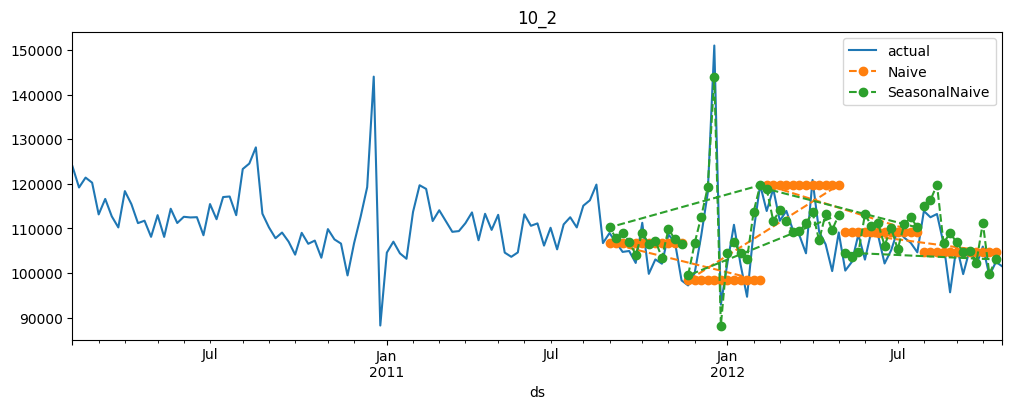

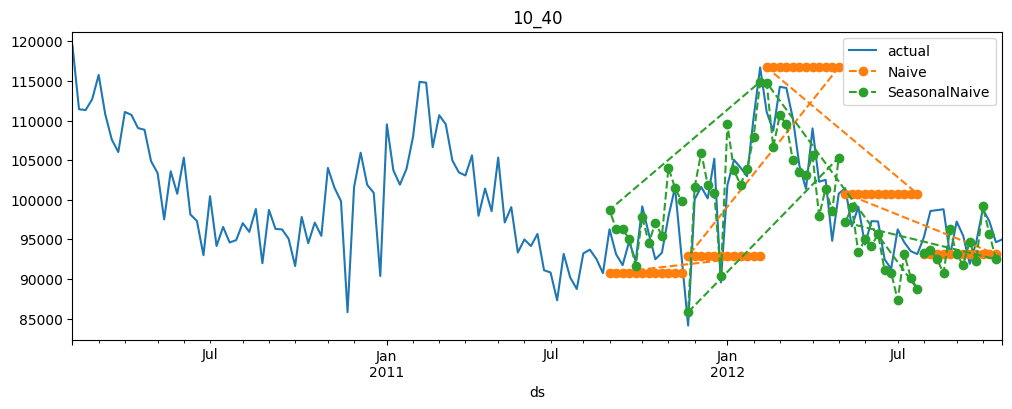

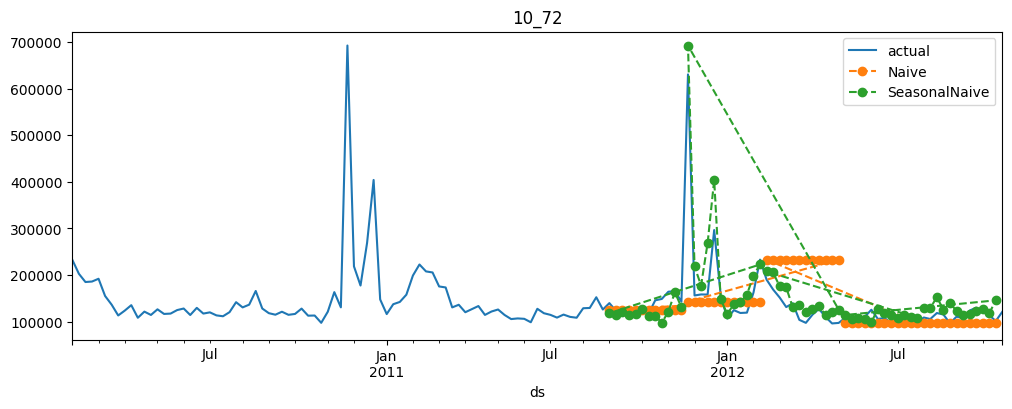

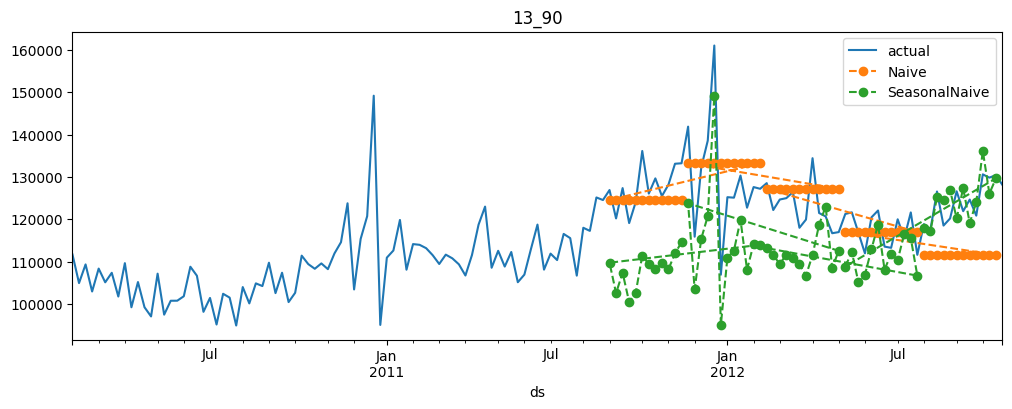

In [45]:
import math

def plot_series_predictions(uid, df_predictions, df_actual):
    plt.figure(figsize=(12,4))
    # actual full series
    s = df_actual[df_actual["unique_id"]==uid].set_index("ds")["y"]
    s.plot(label="actual")
    # plot model preds (use last fold predictions only for clarity)
    preds = df_predictions[(df_predictions["unique_id"]==uid)]
    for model_name, grp in preds.groupby("model"):
        # join predictions by ds
        grp = grp.set_index("ds")["yhat"]
        grp.plot(marker="o", linestyle="--", label=model_name)
    plt.title(uid)
    plt.legend()
    plt.show()

# Example plot for first 4 series
u_list = cv_results_df["unique_id"].unique()[:4]
for uid in u_list:
    plot_series_predictions(uid, cv_results_df, Y_full)


In [47]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor


model_lgb = LGBMRegressor(n_estimators=200)

fcst = MLForecast(
    models=[("lgb", model_lgb)],
    freq="W-FRI",
    lags=[1,52],   # example lags
    date_features=["month","week"],
)

# fit on panel train and forecast
# fcst.fit(train_df, X_df=exog_train)
# preds = fcst.predict(h=h)


In [48]:
cv_results_df.to_csv("cv_predictions_full.csv", index=False)
agg.to_csv("per_series_model_metrics.csv", index=False)
for met in metrics:
    wins[met].to_csv(f"winner_counts_{met}.csv", index=False)
print("Saved CSVs.")


Saved CSVs.
